In [2]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()
from collections import OrderedDict

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

In [3]:
# Plot the predictions.
def leakiness(num_rep, ep_r, ep_ai, n_ns=4.6E6):
    pact = 1 / (1 + np.exp(-ep_ai))
    return (1 + pact * (num_rep / n_ns) * np.exp(-ep_r))**-1


def saturation(num_rep, ep_r, ep_ai, ka_ki, n_sites=2, n_ns=4.6E6):
    pact = 1 / (1 + np.exp(-ep_ai) * ka_ki**n_sites)
    return (1 + pact * (num_rep / n_ns) * np.exp(-ep_r))**-1


def saturation_cred_region(num_rep, ep_r, ep_ai, ka_flatchain, ki_flatchain,
                           n_sites=2, n_ns=4.6E6, mass_frac=0.95):
    pact = 1 / (1 + np.exp(-ep_ai) * (ka_flatchain / ki_flatchain)**n_sites)
    cred_region = np.zeros([2, len(num_rep)])
    for i, R in enumerate(num_rep):
        fc = (1 + pact * (R / n_ns) * np.exp(-ep_r))**-1
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    return cred_region


def dyn_range(num_rep, ep_r, ka_ki, ep_ai=4.5, n_sites=2, n_ns=4.6E6):
    pact_leak = 1 / (1 + np.exp(-ep_ai))
    pact_sat = 1 / (1 + np.exp(-ep_ai) * (ka_ki)**n_sites)
    leak = (1 + pact_leak * (num_rep / n_ns) * np.exp(-ep_r))**-1
    sat = (1 + pact_sat * (num_rep / n_ns) * np.exp(-ep_r))**-1
    return sat - leak


# The following equations are borrowed from Stephanie Barnes.

def pact(IPTG, K_A, K_I, e_AI):
    '''
    Computes the probability that a repressor is active
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    probability that repressor is active
    '''
    pact = (1 + IPTG * 1 / K_A)**2 / \
        (((1 + IPTG * 1 / K_A))**2 + np.exp(-e_AI) * (1 + IPTG * 1 / K_I)**2)
    return pact


def fold_change(IPTG, K_A, K_I, e_AI, R, Op):
    '''
    Computes fold-change for simple repression
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    R : float
        Number of repressors per cell
    Op : float
        Operator binding energy
    Returns
    -------
    probability that repressor is active
    '''
    return 1 / (1 + R / 5E6 * pact(IPTG, K_A, K_I, e_AI) * np.exp(-Op))


def dyn_cred_region(num_rep, ka_flatchain, ki_flatchain, ep_r, mass_frac=0.95, epsilon=4.5):
    cred_region = np.zeros([2, len(num_rep)])
    ka_ki = ka_flatchain / ki_flatchain
    for i, R in enumerate(num_rep):
        drng = dyn_range(R, ep_r, ka_ki, ep_ai=epsilon)
        cred_region[:, i] = mwc.hpd(drng, mass_frac)
    return cred_region


def EC50(K_A, K_I, e_AI, R, Op):
    '''
    Computes the concentration at which half of the repressors are in the active state
    Parameters
    ----------
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state

    Returns
    -------
    Concentration at which half of repressors are active (EC50)
    '''
    t = 1 + (R / 4.6E6) * np.exp(-Op) + (K_A / K_I)**2 * \
        (2 * np.exp(-e_AI) + 1 + (R / 4.6E6) * np.exp(-Op))
    b = 2 * (1 + (R / 4.6E6) * np.exp(-Op)) + \
        np.exp(-e_AI) + (K_A / K_I)**2 * np.exp(-e_AI)
    return K_A * ((K_A / K_I - 1) / (K_A / K_I - (t / b)**(1 / 2)) - 1)


def ec50_cred_region(num_rep, Op, e_AI, K_A, K_I,
                     mass_frac=0.95):
    cred_region = np.zeros([2, len(num_rep)])
    for i, R in enumerate(num_rep):
        t = 1 + (R / 4.6E6) * np.exp(-Op) + (K_A / K_I)**2 * \
            (2 * np.exp(-e_AI) + 1 + (R / 4.6E6) * np.exp(-Op))
        b = 2 * (1 + (R / 4.6E6) * np.exp(-Op)) + \
            np.exp(-e_AI) + (K_A / K_I)**2 * np.exp(-e_AI)
        ec50_rng = K_A * ((K_A / K_I - 1) / (K_A / K_I - (t / b)**(1 / 2)) - 1)
        cred_region[:, i] = mwc.hpd(ec50_rng, mass_frac)
    return cred_region


def effective_Hill(K_A, K_I, e_AI, R, Op):
    '''
    Computes the effective Hill coefficient
    Parameters
    ----------
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    effective Hill coefficient
    '''
    c = EC50(K_A, K_I, e_AI, R, Op)
    return 2 / (fold_change(c, K_A, K_I, e_AI, R, Op) - fold_change(0, K_A, K_I, e_AI, R, Op)) *\
        (-(fold_change(c, K_A, K_I, e_AI, R, Op))**2 * R / 5E6 * np.exp(-Op) *
         2 * c * np.exp(-e_AI) * (1 / K_A * (1 + c / K_A) * (1 + c / K_I)**2 - 1 / K_I *
                                  (1 + c / K_A)**2 * (1 + c / K_I)) / ((1 + c / K_A)**2 + np.exp(-e_AI) * (1 + c / K_I)**2)**2)


def effective_hill_cred(num_rep, Op, e_AI, K_A, K_I,
                        mass_frac=0.95):
    cred_region = np.zeros([2, len(num_rep)])
    for i, R in enumerate(num_rep):
        # Compute the EC50
        c = EC50(K_A, K_I, e_AI, R, Op)
        # Compute the hill
        e_hill = 2 / (fold_change(c, K_A, K_I, e_AI, R, Op) - fold_change(0, K_A, K_I, e_AI, R, Op)) *\
            (-(fold_change(c, K_A, K_I, e_AI, R, Op))**2 * R / 5E6 * np.exp(-Op) *
             2 * c * np.exp(-e_AI) * (1 / K_A * (1 + c / K_A) * (1 + c / K_I)**2 - 1 / K_I *
                                      (1 + c / K_A)**2 * (1 + c / K_I)) / ((1 + c / K_A)**2 + np.exp(-e_AI) * (1 + c / K_I)**2)**2)
        cred_region[:, i] = mwc.hpd(e_hill, mass_frac)

    return cred_region



In [111]:

# Load all of the 2018 DNA flow data.
flow_files = glob.glob('../../../processing/2018*DNA*flow*/output/*fold_change.csv')
dfs = [pd.read_csv(f, comment='#') for f in flow_files]
flow_data = pd.concat(dfs, axis=0)
# flow_data = flow_data[(flow_data.mutant!='Q21M') | (flow_data.IPTGuM != 0.0) ]

# # Load the microscopy data
# mic_files = glob.glob('../../../processing/2018*microscopy*/output/*fold_change.csv')
# dfs = [pd.read_csv(f) for f in mic_files]
# mic_data = pd.concat(dfs, axis=0)
# mic_data['IPTGuM'] = 0.0
# mic_data['operator'] = 'O2'

# df = pd.concat([flow_data, mic_data], ignore_index=True)
df = flow_data
df = df[(df['fold_change'] >= 0.0) & (df['fold_change'] <= 1.3)]
df = df.reset_index()

# Now we remove the autofluorescence and delta values
df = df[(df.mutant != 'auto') & (df.mutant != 'delta') & (df.operator == 'O2')
       & (df.mutant != 'none')]

# Restart index
df = df.reset_index()

df.head()

,level_0,index,IPTGuM,Unnamed: 0,date,fold_change,mean_FITC_H,mutant,operator,repressors,strain,username
0,0,0,0.0,20,20180213,0.011940,5082.246850,Q21M,O2,260.0,R260,gchure
1,1,2,0.0,39,20180213,0.020366,5174.999030,Q21M,O2,124.0,R124,gchure
2,4,8,0.1,17,20180213,0.001042,5032.407459,Q21M,O2,260.0,R260,gchure
3,6,11,0.1,34,20180213,0.004665,5077.456220,wt,O2,260.0,R260,gchure
4,7,12,0.1,63,20180213,0.007875,5117.362892,Q21M,O2,60.0,R60,gchure


In [112]:
# df_temp = df[df.strain=='R260']
# Compute the dynamic range.
grouped = pd.groupby(df, 'mutant')
drs = []
for g, d in grouped:
    unique_IPTG = d.IPTGuM.unique()
    min_IPTG = np.min(unique_IPTG)
    max_IPTG = np.max(unique_IPTG)
    # Group the new data by repressors.
    grouped_rep = pd.groupby(d, ['strain', 'date', 'username'])
    rbs_ind = {'R60': 0, 'R124': 1, 'R260': 2, 'R1220': 3}
    rep_dr = [[], [], [], []]
    rep_std = []
    for g_rep, d_rep in grouped_rep:
        if np.min(d_rep.IPTGuM) != min_IPTG:
            continue
        if np.max(d_rep.IPTGuM) != max_IPTG:
            continue
        
        dr = d_rep[d_rep.IPTGuM == max_IPTG].fold_change.values - \
            d_rep[d_rep.IPTGuM == min_IPTG].fold_change.values

        rep_dr[rbs_ind[g_rep[0]]].append(dr[0])

    # Compute the means.
    for i, dr in enumerate(rep_dr):
        rep_dr[i] = np.mean(dr)
        rep_std.append(np.std(dr) / np.sqrt(len(dr)))

    reps = np.sort(df.repressors.unique())
    dr_df = pd.DataFrame([reps, rep_dr, rep_std]).T
    dr_df.columns = ['repressors', 'dynamic_range', 'err']
    dr_df.insert(0, 'mutant', g)
    drs.append(dr_df)
drng = pd.concat(drs, axis=0)

/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  # Remove the CWD from sys.path while we load stuff.
/Users/nathanb/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nathanb/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods


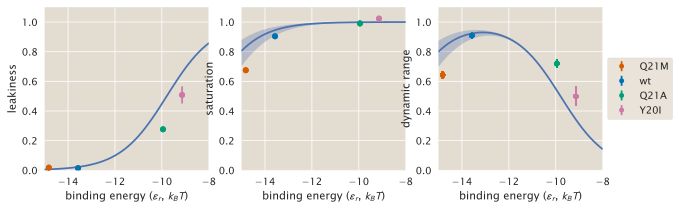

In [114]:
# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

mut_list = {'wt':0, 'Q21A':1, 'Q21M':2, 'Y20I':3, 'Q294V':4, 'F164T':5, 'Q294R':6}

########################
ea = -4.935
ei = 0.635
ka_ki = np.exp(-ea) / np.exp(-ei)
ka_ki_min = np.exp(-(ea+0.2)) / np.exp(-(ei-0.08))
ka_ki_max = np.exp(-(ea-0.2)) / np.exp(-(ei+0.08))

########################

fig, ax = plt.subplots(1,3,figsize=(10,3))

rep_nc = 260
ep_r = np.linspace(-15,-8)
ep_mut = {'Y20I':-9.137, 'Q21A':-9.951, 'Q21M':-14.820, 'wt':-13.573} 
ep_ai = 4.5
Ka = np.linspace(10,1000)

# leakiness
ax[0].plot(ep_r, leakiness(rep_nc, ep_r, ep_ai, n_ns=4.6E6))
ax[0].set_xlim(ep_r.min(),ep_r.max())
ax[0].set_ylim(0,1.1)
ax[0].set_ylabel('leakiness')
ax[0].set_xlabel(r'binding energy ($\varepsilon_r$, $k_B T$)')

# saturation
cred_min = saturation(rep_nc, ep_r, ep_ai, ka_ki_min, n_sites=2, n_ns=4.6E6)
cred_max = saturation(rep_nc, ep_r, ep_ai, ka_ki_max, n_sites=2, n_ns=4.6E6)

ax[1].plot(ep_r, saturation(rep_nc, ep_r, ep_ai, ka_ki, n_sites=2, n_ns=4.6E6))
ax[1].fill_between(ep_r, cred_min, cred_max, alpha=0.3)
ax[1].set_xlim(ep_r.min(),ep_r.max())
ax[1].set_ylim(0,1.1)
ax[1].set_ylabel('saturation')
ax[1].set_xlabel(r'binding energy ($\varepsilon_r$, $k_B T$)')

# dynamic range
cred_min = dyn_range(rep_nc, ep_r, ka_ki_min, ep_ai=4.5, n_sites=2, n_ns=4.6E6)
cred_max = dyn_range(rep_nc, ep_r, ka_ki_max, ep_ai=4.5, n_sites=2, n_ns=4.6E6)

ax[2].plot(ep_r, dyn_range(rep_nc, ep_r, ka_ki, ep_ai=4.5, n_sites=2, n_ns=4.6E6))
ax[2].fill_between(ep_r, cred_min, cred_max, alpha=0.3)
ax[2].set_xlim(ep_r.min(),ep_r.max())
ax[2].set_ylim(0,1.1)
ax[2].set_ylabel('dynamic range')
ax[2].set_xlabel(r'binding energy ($\varepsilon_r$, $k_B T$)')

################################
# data
################################

# Plot the leakiness and saturation data.
grouped = pd.groupby(df[df.strain=='R260'], ['mutant', 'repressors'])
for g, d in grouped:    
    # Extract the unique IPTG values.
    unique_IPTG = d['IPTGuM'].unique()

    # Slice the min and max IPTG values.
    leak_vals = d[d['IPTGuM'] == np.min(unique_IPTG)].fold_change
    sat_vals = d[d['IPTGuM'] == np.max(unique_IPTG)].fold_change

    # Compute the mean and standard errors of reach.
    mean_leak = np.mean(leak_vals)
    sem_leak = np.std(leak_vals) / np.sqrt(len(leak_vals))
    mean_sat = np.mean(sat_vals)
    sem_sat = np.std(sat_vals) / np.sqrt(len(sat_vals))
     
    # Plot the data with the appropriate legends..
    ax[0].plot(ep_mut[g[0]], mean_leak, 'o',markersize=6, color=colors[mut_list[g[0]]])
    ax[0].errorbar(ep_mut[g[0]], mean_leak, sem_leak, linestyle='none',
                    fmt='o', markersize=6, color=colors[mut_list[g[0]]])  
    ax[1].plot(ep_mut[g[0]], mean_sat, 'o',markersize=6, color=colors[mut_list[g[0]]])
    ax[1].errorbar(ep_mut[g[0]], mean_sat, sem_sat, linestyle='none',
                    fmt='o', markersize=6, color=colors[mut_list[g[0]]])  
    
##########
# data dynamic range
#########
drng_260 = drng[drng.repressors==260]
for i, mut in enumerate(df.mutant):
    dyn_rng = drng_260[drng_260.mutant == mut]
    ax[2].errorbar(ep_mut[mut], dyn_rng.dynamic_range, yerr=dyn_rng.err, fmt='o', linestyle='none',
               markersize=5, color=colors[mut_list[mut]], label=mut)


# for plotting the legend (removing replicate labels)
handles, labels = ax[2].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[2].legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout()

plt.savefig('20180430_properties_DNAmut.pdf',bbox_inches='tight')

198.343425409
347.234380479
262.43409924


In [5]:

# # Load all of the 2018 DNA flow data.
# flow_files = glob.glob('../../../processing/2018*IND*flow*/output/*fold_change.csv')
# dfs = []
# # [pd.read_csv(f, comment='#') for f in flow_files]
# count = 0
# for f in flow_files:
#     dfs_temp = pd.read_csv(f, comment='#')
#     dfs_temp['run'] = count
#     dfs = np.append(dfs,dfs_temp)
#     count += 1
    

array([0, 20180409, 'nbellive', ..., 260.0, 1.727377768282389, 6], dtype=object)

In [115]:

# Load all of the 2018 DNA flow data.
flow_files = glob.glob('../../../processing/2018*IND*flow*/output/*fold_change.csv')
dfs = pd.DataFrame()
# [pd.read_csv(f, comment='#') for f in flow_files]
count = 0
for f in flow_files:
    dfs_temp = pd.read_csv(f, comment='#')
    dfs_temp['run'] = count
    dfs = dfs.append(dfs_temp)
    count += 1
    
# flow_data = pd.concat(dfs, axis=0)
# flow_data = flow_data[(flow_data.mutant!='Q21M') | (flow_data.IPTGuM != 0.0) ]

# # Load the microscopy data
# mic_files = glob.glob('../../../processing/2018*microscopy*/output/*fold_change.csv')
# dfs = [pd.read_csv(f) for f in mic_files]
# mic_data = pd.concat(dfs, axis=0)
# mic_data['IPTGuM'] = 0.0
# mic_data['operator'] = 'O2'

# df = pd.concat([flow_data, mic_data], ignore_index=True)
df = dfs
df = df[(df['fold_change'] >= 0.0) & (df['fold_change'] <= 1.3)]
df = df.reset_index()

# Now we remove the autofluorescence and delta values
df = df[(df.mutant != 'auto') & (df.mutant != 'delta') & (df.operator == 'O2')
       & (df.mutant != 'none')]

# Restart index
df = df.reset_index()

df = df[df.repressors==260]
df = df[(df.mutant!='Q21A-Q294K') & (df.mutant!='Q294R')]
df.head()

,level_0,index,Unnamed: 0,date,username,mutant,operator,strain,IPTGuM,mean_FITC_H,repressors,fold_change,run
0,2,4,4,20180409,nbellive,F164T,O2,R260,0.0,5325.494040,260.0,0.002297,0
1,5,7,7,20180409,nbellive,wt,O2,R260,0.1,5187.629503,260.0,0.012561,0
2,6,8,8,20180409,nbellive,Q294V,O2,R260,0.1,5060.321179,260.0,0.005620,0
3,7,9,9,20180409,nbellive,F164T,O2,R260,0.1,5246.723943,260.0,0.015783,0
4,10,12,12,20180409,nbellive,wt,O2,R260,5.0,5390.200563,260.0,0.025843,0


In [116]:
# df_temp = df[df.strain=='R260']
# Compute the dynamic range.
grouped = pd.groupby(df, 'mutant')
drs = []
drng_ind = []
for g, d in grouped:
    print(g)
    unique_IPTG = d.IPTGuM.unique()
    min_IPTG = np.min(unique_IPTG)
    max_IPTG = np.max(unique_IPTG)
    # Group the new data by repressors.
    grouped_rep = pd.groupby(d, ['strain', 'run', 'username'])
    rbs_ind = {'R60': 2, 'R124': 1, 'R260': 0, 'R1220': 3}
#     rep_dr = [[], [], [], []]
    rep_dr =[[]]
    rep_std = []
    for g_rep, d_rep in grouped_rep:
        if np.min(d_rep.IPTGuM) != min_IPTG:
            continue
        if np.max(d_rep.IPTGuM) != max_IPTG:
            continue
        
        dr = d_rep[d_rep.IPTGuM == max_IPTG].fold_change.values - \
            d_rep[d_rep.IPTGuM == min_IPTG].fold_change.values

        rep_dr[rbs_ind[g_rep[0]]].append(dr[0])

    # Compute the means.
    for i, dr in enumerate(rep_dr):
        rep_dr[i] = np.mean(dr)
        rep_std.append(np.std(dr) / np.sqrt(len(dr)))

    reps = np.sort(df.repressors.unique())

    dr_df = pd.DataFrame([reps, rep_dr, rep_std]).T
    dr_df.columns = ['repressors', 'dynamic_range', 'err']
    dr_df.insert(0, 'mutant', g)

    drs.append(dr_df)
drng_ind = pd.concat(drs, axis=0)

F164T
Q294V
wt


/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  if sys.path[0] == '':


/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods


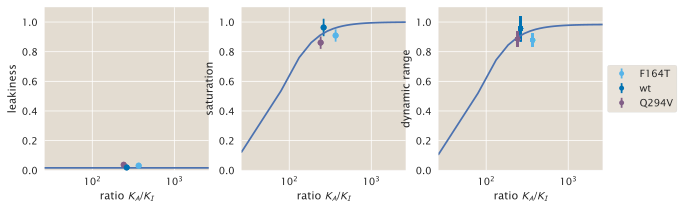

In [117]:
# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

mut_list = {'wt':0, 'Q21A':1, 'Q21M':2, 'Y20I':3, 'Q294V':4, 'F164T':5, 'Q294R':6}

########################
# wild-type values
ea = -4.935
ei = 0.635
ka_ki = np.exp(-ea) / np.exp(-ei)
# ka_ki_ = np.logspace(np.log(ka_ki/1.25),np.log(1.25*ka_ki))
ka_ki_ = np.linspace(ka_ki/10,10*ka_ki)
ka_ki_min = np.exp(-(ea+0.2)) / np.exp(-(ei-0.08))
ka_ki_max = np.exp(-(ea-0.2)) / np.exp(-(ei+0.08))

F164T_ratio = np.exp(4.997)/np.exp(-0.910)
Q294V_ratio = np.exp(6.362)/np.exp(0.875)
KaKi_list = {'F164T':F164T_ratio, 'Q294V':Q294V_ratio, 'wt':ka_ki,
            'Q294R':0.1}

########################

fig, ax = plt.subplots(1,3,figsize=(10,3))

rep_nc = 260
ep_r = -13.9
ep_mut = {'Y20I':-9.137, 'Q21A':-9.951, 'Q21M':-14.820, 'wt':-13.573} 
ep_ai = 4.5



# leakiness
ax[0].plot(ka_ki_, leakiness(rep_nc, np.ones(len(ka_ki_))*ep_r, ep_ai, n_ns=4.6E6))
ax[0].set_xlim(ka_ki_.min(),ka_ki_.max())
ax[0].set_ylim(0,1.1)
ax[0].set_xscale('log')
ax[0].set_ylabel('leakiness')
ax[0].set_xlabel(r'ratio $K_A/K_I$')

# saturation
# cred_min = saturation(rep_nc, ep_r, ep_ai, ka_ki_min, n_sites=2, n_ns=4.6E6)
# cred_max = saturation(rep_nc, ep_r, ep_ai, ka_ki_max, n_sites=2, n_ns=4.6E6)

ax[1].plot(ka_ki_, saturation(rep_nc, ep_r, ep_ai, ka_ki_, n_sites=2, n_ns=4.6E6))
# ax[1].fill_between(ep_r, cred_min, cred_max, alpha=0.3)
ax[1].set_xlim(ka_ki_.min(),ka_ki_.max())
ax[1].set_ylim(0,1.1)
ax[1].set_xscale('log')
ax[1].set_ylabel('saturation')
ax[1].set_xlabel(r'ratio $K_A/K_I$')


# dynamic range
cred_min = dyn_range(rep_nc, ep_r, ka_ki_min, ep_ai=4.5, n_sites=2, n_ns=4.6E6)
cred_max = dyn_range(rep_nc, ep_r, ka_ki_max, ep_ai=4.5, n_sites=2, n_ns=4.6E6)

ax[2].plot(ka_ki_, dyn_range(rep_nc, ep_r, ka_ki_, ep_ai=4.5, n_sites=2, n_ns=4.6E6))
# ax[2].fill_between(ep_r, cred_min, cred_max, alpha=0.3)
ax[2].set_xlim(ka_ki_.min(),ka_ki_.max())
ax[2].set_ylim(0,1.1)
ax[2].set_xscale('log')
ax[2].set_ylabel('dynamic range')
ax[2].set_xlabel(r'ratio $K_A/K_I$')

# ################################
# # data
# ################################

# Plot the leakiness and saturation data.
grouped = pd.groupby(df[df.strain=='R260'], ['mutant', 'repressors'])
for g, d in grouped:    
    # Extract the unique IPTG values.
    unique_IPTG = d['IPTGuM'].unique()

    # Slice the min and max IPTG values.
    leak_vals = d[d['IPTGuM'] == np.min(unique_IPTG)].fold_change
    sat_vals = d[d['IPTGuM'] == np.max(unique_IPTG)].fold_change

    # Compute the mean and standard errors of reach.
    mean_leak = np.mean(leak_vals)
    sem_leak = np.std(leak_vals) / np.sqrt(len(leak_vals))
    mean_sat = np.mean(sat_vals)
    sem_sat = np.std(sat_vals) / np.sqrt(len(sat_vals))
     
    # Plot the data with the appropriate legends..
    ax[0].plot(KaKi_list[g[0]], mean_leak, 'o',markersize=6, color=colors[mut_list[g[0]]])
    ax[0].errorbar(KaKi_list[g[0]], mean_leak, sem_leak, linestyle='none',
                    fmt='o', markersize=6, color=colors[mut_list[g[0]]])  
    ax[1].plot(KaKi_list[g[0]], mean_sat, 'o',markersize=6, color=colors[mut_list[g[0]]])
    ax[1].errorbar(KaKi_list[g[0]], mean_sat, sem_sat, linestyle='none',
                    fmt='o', markersize=6, color=colors[mut_list[g[0]]])  
    
# ##########
# # data dynamic range
# #########
drng_260 = drng_ind[drng_ind.repressors==260]
for i, mut in enumerate(df.mutant):
    dyn_rng = drng_260[drng_260.mutant == mut]
    ax[2].errorbar(KaKi_list[mut], dyn_rng.dynamic_range, yerr=dyn_rng.err, fmt='o', linestyle='none',
               markersize=5, color=colors[mut_list[mut]], label=mut)


# for plotting the legend (removing replicate labels)
handles, labels = ax[2].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[2].legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout()

plt.savefig('20180430_properties_INDratio_mut.pdf',bbox_inches='tight')

/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods


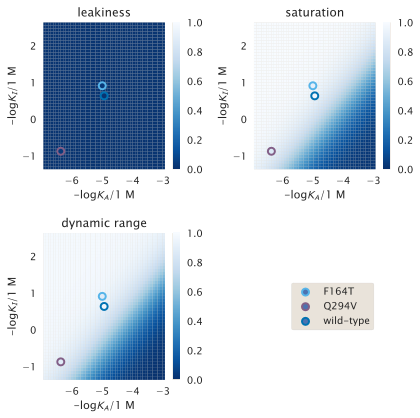

In [124]:
# fig, ax = plt.subplots(1,3,figsize=(10,3))

#here's our data to plot, all normal Python lists
x = np.linspace((ea-2), (ea+2))
y = np.linspace((ei-2), (ei+2))

#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

data = plt.cm.jet([x, y])

plt.figure(figsize=(6,6))

# Leakiness
plt.subplot(2, 2, 1)
z_leak = leakiness(rep_nc, np.ones([len(x),len(x)])*ep_r, ep_ai, n_ns=4.6E6)
sc1 = plt.pcolormesh(x, y, z_leak, vmin=0.0,vmax=1.0, cmap='Blues_r')

# Plot the leakiness data
grouped = pd.groupby(df[df.strain=='R260'], ['mutant', 'repressors'])
for g, d in grouped:    
    # Extract the unique IPTG values.
    unique_IPTG = d['IPTGuM'].unique()

    # Slice the min IPTG values.
    leak_vals = d[d['IPTGuM'] == np.min(unique_IPTG)].fold_change

    # Compute the mean and standard errors of each.
    mean_leak = np.mean(leak_vals)
    sem_leak = np.std(leak_vals) / np.sqrt(len(leak_vals))
    if g[0] == 'F164T':
        plt.scatter(-4.997,0.910, edgecolors=colors[mut_list['F164T']],
               c=mean_leak, cmap='Blues_r', linewidth=2,
               vmin=0,vmax=1.0)
    if g[0] == 'Q294V':     
        plt.scatter(-6.362,-0.875, edgecolors=colors[mut_list['Q294V']],
           c=mean_leak, cmap='Blues_r', linewidth=2,
           vmin=0,vmax=1.0)
    if g[0] == 'wt':
        plt.scatter(ea,ei, edgecolors=colors[mut_list['wt']],
       c=mean_leak, cmap='Blues_r', linewidth=2,
       vmin=0,vmax=1.0)

plt.xlabel(r'-log$K_A$/1 M')
plt.ylabel(r'-log$K_I$/1 M')
plt.colorbar(sc1)
plt.title('leakiness')


# # # saturation
plt.subplot(2, 2, 2)
z_sat = saturation(rep_nc, ep_r, ep_ai, np.exp(-x)/np.exp(-y), n_sites=2, n_ns=4.6E6)
sc2 = plt.pcolormesh(x, y, z_sat, vmin=0,vmax=1.0, cmap='Blues_r')


# Plot the saturation data.
grouped = pd.groupby(df[df.strain=='R260'], ['mutant', 'repressors'])
for g, d in grouped:    
    # Extract the unique IPTG values.
    unique_IPTG = d['IPTGuM'].unique()

    # Slice the max IPTG values.
    sat_vals = d[d['IPTGuM'] == np.max(unique_IPTG)].fold_change

    # Compute the mean and standard errors of each.
    mean_sat = np.mean(sat_vals)
    sem_sat = np.std(sat_vals) / np.sqrt(len(sat_vals))
    
    if g[0] == 'F164T':
        plt.scatter(-4.997,0.910, edgecolors=colors[mut_list['F164T']],
               c=mean_sat, cmap='Blues_r', linewidth=2,
               vmin=0,vmax=1.0)
    if g[0] == 'Q294V':     
        plt.scatter(-6.362,-0.875, edgecolors=colors[mut_list['Q294V']],
           c=mean_sat, cmap='Blues_r', linewidth=2,
           vmin=0,vmax=1.0)
    if g[0] == 'wt':
        plt.scatter(ea,ei, edgecolors=colors[mut_list['wt']],
           c=mean_sat, cmap='Blues_r', linewidth=2,
           vmin=0,vmax=1.0)
            
plt.xlabel(r'-log$K_A$/1 M')
plt.ylabel(r'-log$K_I$/1 M')
plt.colorbar(sc2)
plt.title('saturation')

# # # dynamic range
ax = plt.subplot(2, 2, 3)
z_sat = dyn_range(rep_nc, ep_r, np.exp(-x)/np.exp(-y), ep_ai=4.5, n_sites=2, n_ns=4.6E6)
# z_sat = saturation(rep_nc, ep_r, ep_ai, np.log(-(x-y)), n_sites=2, n_ns=4.6E6)
sc3 = plt.pcolormesh(x, y, z_sat, vmin=0,vmax=1.0, cmap='Blues_r')
dyn_rng = drng_260[drng_260.mutant == 'F164T']
plt.scatter(-4.997,0.910, edgecolors=colors[mut_list['F164T']],
           c=dyn_rng.dynamic_range, cmap='Blues_r', linewidth=2,
           vmin=0,vmax=1.0, label='F164T')
dyn_rng = drng_260[drng_260.mutant == 'Q294V']
plt.scatter(-6.362,-0.875, edgecolors=colors[mut_list['Q294V']],
           c=dyn_rng.dynamic_range, cmap='Blues_r', linewidth=2,
           vmin=0,vmax=1.0, label='Q294V')
dyn_rng = drng_260[drng_260.mutant == 'wt']
plt.scatter(ea,ei, edgecolors=colors[mut_list['wt']],
           c=dyn_rng.dynamic_range, cmap='Blues_r', linewidth=2,
           vmin=0,vmax=1.0, label='wild-type')
plt.xlabel(r'-log$K_A$/1 M')
plt.ylabel(r'-log$K_I$/1 M')
plt.colorbar(sc3)
plt.title('dynamic range')

handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(2, 0.5))


# plt.subplot(2, 2, 4)
# plt.legend(by_label.values(), by_label.keys())

# # for plotting the legend (removing replicate labels)
# handles, labels = ax.get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(0.25, 0.5))


plt.tight_layout()

plt.savefig('20180430_properties_IND_Ka_Ki_mut.pdf')

# fig.colorbar(im)

# plt.subplots_adjust(wspace=0.4, hspace=0.4)

# F164T_Ka = np.exp(4.997)
# F164T_Ki = np.exp(-0.910)
# Q294V_Ka = np.exp(6.362)
# Q294V_Ki = np.exp(0.875)

0    0.955331
Name: dynamic_range, dtype: float64

50